In [1]:
from ultralytics.data.annotator import auto_annotate

In [2]:
BASE_DIR = 'sample_images/'
IMAGES_DIR = BASE_DIR + 'images/'
ANNOTATIONS_DIR = BASE_DIR + 'images_auto_annotate_labels/'

In [ ]:
auto_annotate(data=IMAGES_DIR, det_model="yolov8m.pt", sam_model="sam_b.pt", device="cuda:0", output_dir=ANNOTATIONS_DIR)

# UPD: ADDED CONVERSION TO COCO WITHOUT ROBOFLOW

By setting varibales 'categories', 'yolo_directory', 'images_directory' and 'output_json' we now can bypass conversion to COCO segment using roboflow and do it with the following chunk of code

In [5]:
import json
import os
from PIL import Image
import numpy as np
from datetime import datetime

def create_coco_structure():
    """Create the basic COCO JSON structure"""
    return {
        "info": {
            "year": 2024,
            "version": "1.0",
            "description": "Converted from YOLO format",
            "contributor": "OlegMirasov",
            "date_created": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
        },
        "images": [],
        "annotations": [],
        "categories": []
    }

def convert_yolo_to_coco(
    yolo_dir,
    image_dir,
    output_json_path,
    categories_list
):
    """
    Convert YOLO segmentation format to COCO format
    
    Args:
        yolo_dir (str): Directory containing YOLO .txt files
        image_dir (str): Directory containing image files
        output_json_path (str): Path to save the output JSON file
        categories_list (list): List of category names
    """
    
    # Initialize COCO format structure
    coco_format = create_coco_structure()
    
    # Add categories
    for cat_id, cat_name in enumerate(categories_list):
        coco_format["categories"].append({
            "id": cat_id,
            "name": cat_name,
            "supercategory": "none"
        })
    
    # Initialize counters
    image_id = 0
    annotation_id = 0
    
    # Process each annotation file
    for txt_file in sorted(os.listdir(yolo_dir)):
        if not txt_file.endswith('.txt'):
            continue
            
        image_ = [img for img in os.listdir(image_dir) if os.path.splitext(img)[0]==os.path.splitext(txt_file)[0]][0]
        image_file = os.path.splitext(txt_file)[0] + '.jpg'  # assuming .jpg
        image_file = image_
        image_path = os.path.join(image_dir, image_file)
        
        if not os.path.exists(image_path):
            print(f"Warning: Image {image_file} not found, skipping...")
            continue
        
        with Image.open(image_path) as img:
            width, height = img.size
        
        coco_format["images"].append({
            "id": image_id,
            "file_name": image_file,
            "width": width,
            "height": height
        })
        
        txt_path = os.path.join(yolo_dir, txt_file)
        with open(txt_path, 'r') as f:
            for line in f.readlines():
                data = line.strip().split()
                if len(data) < 8:  # minimum points needed for a polygon (3 points = 6 values + class)
                    continue
                    
                # Parse data
                class_id = int(data[0])
                if (class_id != 47):
                    continue
                polygons = []
                
                # Convert YOLO polygon format (normalized) to COCO format (absolute)
                points = data[1:]
                for i in range(0, len(points), 2):
                    x = float(points[i]) * width
                    y = float(points[i + 1]) * height
                    polygons.extend([x, y])
                
                # Calculate area using shoelace formula
                poly_points = np.array(polygons).reshape(-1, 2)
                area = abs(np.sum(np.cross(poly_points, np.roll(poly_points, -1, axis=0)))) / 2
                
                # Get bbox from polygon points
                x_min = min(polygons[::2])
                y_min = min(polygons[1::2])
                x_max = max(polygons[::2])
                y_max = max(polygons[1::2])
                bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
                
                # Add annotation
                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": class_id,
                    "segmentation": [polygons],
                    "area": area,
                    "bbox": bbox,
                    "iscrowd": 0
                })
                
                annotation_id += 1
        
        image_id += 1
    
    with open(output_json_path, 'w') as f:
        json.dump(coco_format, f, indent=2)
    
    print(f"Conversion completed. Processed {image_id} images and {annotation_id} annotations.")


In [6]:
categories = [
    "apple"
]

yolo_directory = ANNOTATIONS_DIR
images_directory = IMAGES_DIR
output_json = ANNOTATIONS_DIR + "\\annotations.json"

convert_yolo_to_coco(
    yolo_dir=yolo_directory,
    image_dir=images_directory,
    output_json_path=output_json,
    categories_list=categories
)

Conversion completed. Processed 6 images and 64 annotations.


C:\Users\Spidrre\AppData\Local\Temp\ipykernel_9924\2479075642.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "date_created": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")


----------------------------------------


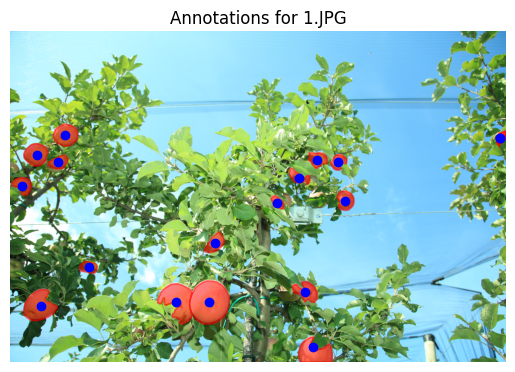

          x_abs        y_abs  x_rel  y_rel
0   3432.277393  3571.666667   0.61   0.95
1   3796.671189  1915.806781   0.68   0.51
2   2248.907693  3059.698463   0.40   0.82
3    299.973607  1394.372434   0.05   0.37
4    623.514354  1175.279904   0.11   0.31
5   3339.581593  2948.039753   0.59   0.79
6    544.730469  1474.839847   0.10   0.39
7   3715.356644  1482.090910   0.66   0.40
8   2321.400577  2400.132566   0.41   0.64
9    139.159375  1745.171878   0.02   0.47
10  3474.737987  1454.615721   0.62   0.39
11  1884.420200  3063.935162   0.34   0.82
12  3270.620914  1658.702611   0.58   0.44
13   888.412245  2673.020406   0.16   0.71
14  3026.686188  1938.933057   0.54   0.52
15  5550.643305  1212.503185   0.99   0.32
16   349.563830  3104.145390   0.06   0.83
17  5550.337763  1206.622514   0.99   0.32
----------------------------------------


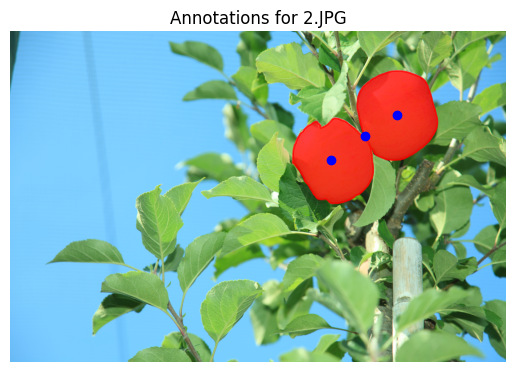

         x_abs        y_abs  x_rel  y_rel
0  3639.092990  1455.709962   0.65   0.39
1  4378.226435   945.879581   0.78   0.25
2  4023.049683  1180.920060   0.72   0.32
----------------------------------------


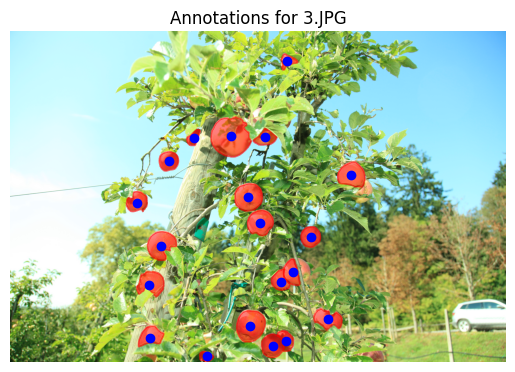

          x_abs        y_abs  x_rel  y_rel
0   2721.466364  3340.955159   0.48   0.89
1   2698.589743  1872.884616   0.48   0.50
2   1434.766079  1938.602344   0.26   0.52
3   2829.930494  2173.544846   0.50   0.58
4   1709.422223  2426.549496   0.30   0.65
5   1798.032349  1468.008821   0.32   0.39
6   3404.579284  2329.987054   0.61   0.62
7   2978.448862  3559.301139   0.53   0.95
8   2499.085044  1190.202345   0.44   0.32
9   1588.208021  3468.270677   0.28   0.93
10  3199.727551  2728.308384   0.57   0.73
11  3071.604730  2834.979728   0.55   0.76
12  2082.345867  1206.266916   0.37   0.32
13  3600.703696  3257.199078   0.64   0.87
14  2228.169901  3674.116501   0.40   0.98
15  3140.263843   338.016287   0.56   0.09
16  1577.502010  2873.879516   0.28   0.77
17  3862.584576  1625.480097   0.69   0.43
18  3124.608519  3500.302326   0.56   0.93
19  2882.053516  1201.056853   0.51   0.32
----------------------------------------


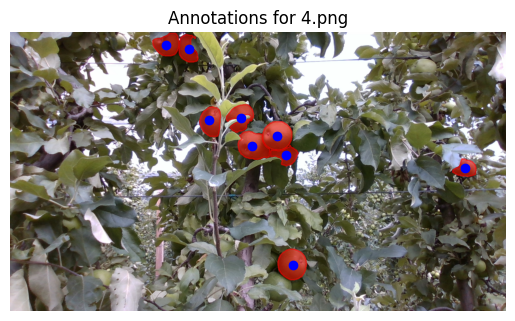

         x_abs       y_abs  x_rel  y_rel
0   728.916667  599.666668   0.57   0.83
1   689.115789  269.052631   0.54   0.37
2   624.865385  294.634615   0.49   0.41
3   513.891566  227.337349   0.40   0.32
4   712.018866  317.509434   0.56   0.44
5   402.569447   32.097223   0.31   0.04
6   461.400001   42.922222   0.36   0.06
7  1172.884610  350.179487   0.92   0.49
8   596.033783  222.148648   0.47   0.31
----------------------------------------


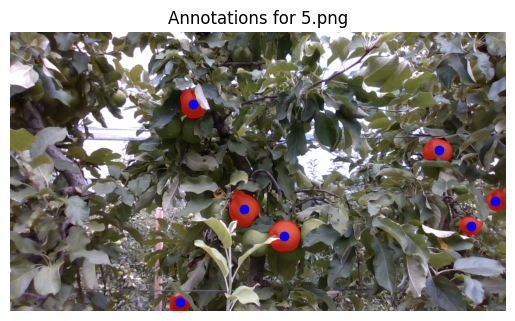

         x_abs       y_abs  x_rel  y_rel
0   706.855932  526.516949   0.55   0.73
1  1105.749997  304.510417   0.86   0.42
2   602.643479  455.669564   0.47   0.63
3   471.271604  185.382715   0.37   0.26
4  1188.108438  500.036144   0.93   0.69
5  1250.727271  435.363636   0.98   0.60
6   438.395834  697.229166   0.34   0.97
----------------------------------------


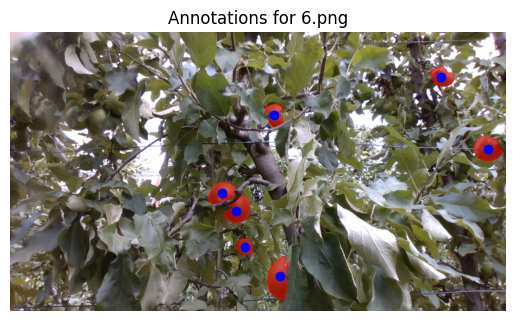

         x_abs       y_abs  x_rel  y_rel
0   583.905262  461.747369   0.46   0.64
1  1111.935064  115.311689   0.87   0.16
2   695.533834  629.691729   0.54   0.87
3  1233.072071  302.018019   0.96   0.42
4   547.032608  415.054347   0.43   0.58
5   604.872726  554.000000   0.47   0.77
6   681.978948  213.663158   0.53   0.30


In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.mask import decode
import pandas as pd

# Load the COCO JSON file
with open(ANNOTATIONS_DIR + "\\annotations.json") as f:
    coco_data = json.load(f)


for target_image_file in os.listdir(IMAGES_DIR):
    list_of_centers = []

    # Find the target image ID based on the file name
    target_image_id = None
    
    for img in coco_data['images']:
        if img['file_name'] == target_image_file:
            target_image_id = img['id']
            break

    if target_image_id is None:
        raise ValueError(f"Image '{target_image_file}' not found in JSON file.")
    
    print('-'*40)

    # Filter annotations for the target image
    target_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == target_image_id]

    # Load the target image
    image_path = target_image_file  # Adjust path if needed
    image = Image.open(os.path.join(IMAGES_DIR, target_image_file))
    image_np = np.array(image)
    h, w, _ = image_np.shape

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(image_np)

    # Loop through the filtered annotations and apply masks
    for ann in target_annotations:
        if isinstance(ann['segmentation'], list):  # Polygon format
            for polygon in ann['segmentation']:
                polygon = np.array(polygon).reshape((-1, 1, 2))
                ax.fill(polygon[:, 0, 0], polygon[:, 0, 1], alpha=0.5, fc='red', edgecolor='r')

                # Calculate centroid of the polygon
                centroid_x = np.mean(polygon[:, 0, 0])
                centroid_y = np.mean(polygon[:, 0, 1])
                
                # Plot the centroid
                ax.plot(centroid_x, centroid_y, 'bo')  # Blue dot for centroid
                list_of_centers.append((centroid_x, centroid_y))

        else:  # RLE format
            mask = decode(ann['segmentation'])
            ax.imshow(mask, alpha=0.5, cmap='Reds')

    plt.title(f"Annotations for {target_image_file}")
    plt.axis('off')
    plt.show()
    formatted_rel_list_of_centers = [ '%.2f' % (elem[0]/w) + ', ' + '%.2f' % (elem[1]/h) for elem in list_of_centers ]
    #print(f'List of centers for {target_image_file}\nAbsolute values {list_of_centers}\nRelative values {formatted_rel_list_of_centers}')

    # Create DataFrame for visualization
    df = pd.DataFrame({
        'x_abs': [elem[0] for elem in list_of_centers],
        'y_abs': [elem[1] for elem in list_of_centers],
        'x_rel': [float(rel.split(',')[0]) for rel in formatted_rel_list_of_centers],
        'y_rel': [float(rel.split(',')[1]) for rel in formatted_rel_list_of_centers]
    })

    # Print centers in absolute and relative coordinates
    print(df)


# OLD VERSION WITH CONVERSION TO COCO-SEGMENT USING ROBOFLOW

These annotations were then uploaded to Roboflow, where they were converted from .txt format to COCO JSON format. This conversion was chosen due to its efficiency compared to implementing it manually. 

link to the ds on Roboflow:
https://universe.roboflow.com/ofpreyklmbl-fkds/hgfh-raqyv/dataset/1

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="-------------------------------") # YOUR API KEY
project = rf.workspace("ofpreyklmbl-fkds").project("hgfh-raqyv")
version = project.version(1)
dataset = version.download("coco-segmentation")

In [25]:
# Put path to the downloaded dataset here
SEGMENT_DS = 'hgfh-1/train'

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.mask import decode
import pandas as pd

# Load the COCO JSON file
with open('hgfh-1/train/_annotations.coco.json') as f:
    coco_data = json.load(f)


for target_image_file in os.listdir(SEGMENT_DS):
    list_of_centers = []

    # Find the target image ID based on the file name
    target_image_id = None
    
    for img in coco_data['images']:
        if img['file_name'] == target_image_file:
            target_image_id = img['id']
            break

    if target_image_id is None:
        raise ValueError(f"Image '{target_image_file}' not found in JSON file.")
    
    print('-'*40)

    # Filter annotations for the target image
    target_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == target_image_id]

    # Load the target image
    image_path = target_image_file  # Adjust path if needed
    image = Image.open(os.path.join(SEGMENT_DS, target_image_file))
    image_np = np.array(image)
    h, w, _ = image_np.shape

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(image_np)

    # Loop through the filtered annotations and apply masks
    for ann in target_annotations:
        if isinstance(ann['segmentation'], list):  # Polygon format
            for polygon in ann['segmentation']:
                polygon = np.array(polygon).reshape((-1, 1, 2))
                ax.fill(polygon[:, 0, 0], polygon[:, 0, 1], alpha=0.5, fc='red', edgecolor='r')

                # Calculate centroid of the polygon
                centroid_x = np.mean(polygon[:, 0, 0])
                centroid_y = np.mean(polygon[:, 0, 1])
                
                # Plot the centroid
                ax.plot(centroid_x, centroid_y, 'bo')  # Blue dot for centroid
                list_of_centers.append((centroid_x, centroid_y))

        else:  # RLE format
            mask = decode(ann['segmentation'])
            ax.imshow(mask, alpha=0.5, cmap='Reds')

    plt.title(f"Annotations for {target_image_file}")
    plt.axis('off')
    plt.show()
    formatted_rel_list_of_centers = [ '%.2f' % (elem[0]/w) + ', ' + '%.2f' % (elem[1]/h) for elem in list_of_centers ]
    #print(f'List of centers for {target_image_file}\nAbsolute values {list_of_centers}\nRelative values {formatted_rel_list_of_centers}')

    # Create DataFrame for visualization
    df = pd.DataFrame({
        'x_abs': [elem[0] for elem in list_of_centers],
        'y_abs': [elem[1] for elem in list_of_centers],
        'x_rel': [float(rel.split(',')[0]) for rel in formatted_rel_list_of_centers],
        'y_rel': [float(rel.split(',')[1]) for rel in formatted_rel_list_of_centers]
    })

    # Print centers in absolute and relative coordinates
    print(df)
